In [944]:
require(readxl)
require(dplyr)
require(ggplot2)
require(AMR)
require(BSDA)
if(!require(wesanderson)){install.packages("wesanderson")}

toBinary = function (column) {
    column = factor(column, labels = c(1))
    column = as.numeric(column)
    column[is.na(column)] = 0
    return(column)
}

getPercent = function(df) {
    df = mutate_all(df, toBinary)
    df = as.data.frame(apply(df, MARGIN = 2, FUN = function(x) {(sum(x)/length(x)) * 100}))
    colnames(df) = c('freq')
    df = tibble::rownames_to_column(df, "action")
    return(df)
}

clean_title = function (x) {
    x = sub("assistant_use.","",x)
    x = sub("e\\.g\\..*","",x)
    x = gsub("_"," ",x)
}

options(repr.matrix.max.rows=200)

Loading required package: wesanderson
Registered S3 method overwritten by 'wesanderson':
  method        from     
  print.palette DescTools


In [1007]:
df = read.csv("~/data/first_look/FalseDoorCharts.csv", check.names = FALSE, na.strings = c(""))

# replace colname spaces with underscores
names(df) <- gsub(" ", "_", names(df))
names(df) <- gsub("'", "", names(df))
names(df) <- gsub(",", "", names(df))

# rename duplicate name
colnames(df)[44] = 'Other_-_Write_In:If_so_which_assistant(s)_do_you_use_the_most_description'

# drop columns
df = select(df, -c(
    'None:If_so_which_assistant(s)_do_you_use_the_most?',
    'Other_-_Write_In:If_so_which_assistant(s)_do_you_use_the_most?',
    'Non-binary/third_gender:What_is_your_gender?',
    'Prefer_to_self-describe:What_is_your_gender?',
    'Echo_Spot:What_Google_devices_do_you_have_and_how_many?_(Leave_boxes_blank_if_you_do_not_have_a_particular_device.)',
    'Echo_Tap:What_Google_devices_do_you_have_and_how_many?_(Leave_boxes_blank_if_you_do_not_have_a_particular_device.)',
    'FireTV:What_Google_devices_do_you_have_and_how_many?_(Leave_boxes_blank_if_you_do_not_have_a_particular_device.)'
))

# rename columns
df = rename(
    df,
    user_description = "Thinking_about_your_internet_browser_which_of_these_statements_best_describes_you?",
    gender = "What_is_your_gender?",
    age = "What_is_your_age?",
    voice_assistant = "Do_you_use_a_voice_assistant?_(e.g._a_digital_assistant_in_a_device_such_as_Apples_Siri_or_Amazons_Alexa)",
    assistant_use_frequency = "How_often_do_you_use_your_voice_assistant?",
    other_devices.google = "Other_(please_let_us_know_the_kind_and_number):What_Google_devices_do_you_have_and_how_many?_(Leave_boxes_blank_if_you_do_not_have_a_particular_device.)",
    other_devices.alexa = "Other_(please_let_us_know_the_kind_and_number):What_Alexa_devices_do_you_have_and_how_many?_(Leave_boxes_blank_if_you_do_not_have_a_particular_device.)"
)

df = rename_at(df, vars(15:33), function(x) {paste0("assistant_use.", x)})
df = rename_at(
    df,
    vars(matches(":If_so_which_assistant\\(s\\)_do_you_use_the_most\\?")),
    function(x) {sub(":If_so_which_assistant\\(s\\)_do_you_use_the_most\\?","",paste0("most_used.", x))}
)
df = rename_at(
    df,
    vars(matches(":What_[A-z]*_devices_do_you_have_and_how_many\\?_\\(Leave_boxes_blank_if_you_do_not_have_a_particular_device.\\)")),
    function(x) {sub(":What_[A-z]*_devices_do_you_have_and_how_many\\?_\\(Leave_boxes_blank_if_you_do_not_have_a_particular_device.\\)","",paste0("num_devices.", x))}
)

names(df) <- gsub("\\(", "", names(df))
names(df) <- gsub("\\)", "", names(df))
names(df) <- gsub("\\?", "", names(df))

# convert to factors
#df = mutate_at(df, vars(matches("assistant_use.")), factor)
df = mutate_at(df, vars(matches("most_used.")), factor)
df$gender = factor(df$gender, levels = c("Man", "Woman"), labels = c("male", "female"))
df$age = ordered(df$age, levels = c('19 - 25 years old',
                                    '26 - 35 years old',
                                    '36 - 45 years old',
                                    '46 - 55 years old',
                                    '56 - 65 years old',
                                    '66 - 75 years old',
                                    '76 + years old'))

df$assistant_use_frequency = ordered(df$assistant_use_frequency, levels = c('Multiple times a day',
                                                                            'Once a day',
                                                                            'A few times a week',
                                                                            'Less than once a week',
                                                                            'Almost never'))

df$assistant_use_frequency.simple = df$assistant_use_frequency 
levels(df$assistant_use_frequency.simple) = c('Multiple times a day',                                                                 
                                              'Once a day',                                                               
                                              'Once a day', 
                                              'Once a day',
                                              'Once a day')

# only use complete responses
df = subset(df, Status == "Complete")

In [593]:
unique(df$voice_assistant)

[1] Yes          No           I'm not sure
Levels: I'm not sure No Yes

In [986]:
# number of participants
print(paste("Number of participants:", nrow(df)), quote=FALSE)
print(paste("Number of male participants:", nrow(subset(df,gender == 'male'))), quote=FALSE)
print(paste("Number of female participants:", nrow(subset(df,gender == 'female'))), quote=FALSE)
print(paste("Number of participants who use add-ons:", nrow(subset(df,Addon2 == 'addon-true'))), quote=FALSE)
print(paste("Number of participants who don't use add-ons:", nrow(subset(df,Addon2 != 'addon-true'))), quote=FALSE)
print(paste("Number of participants who use a voice assistant:", nrow(subset(df,voice_assistant == 'Yes'))), quote=FALSE)
print(paste("Number of participants who don't use a voice assistant:", nrow(subset(df,voice_assistant == 'No'))), quote=FALSE)

[1] Number of participants: 1306
[1] Number of male participants: 1012
[1] Number of female participants: 205
[1] Number of participants who use add-ons: 1115
[1] Number of participants who don't use add-ons: 191
[1] Number of participants who use a voice assistant: 969
[1] Number of participants who don't use a voice assistant: 328


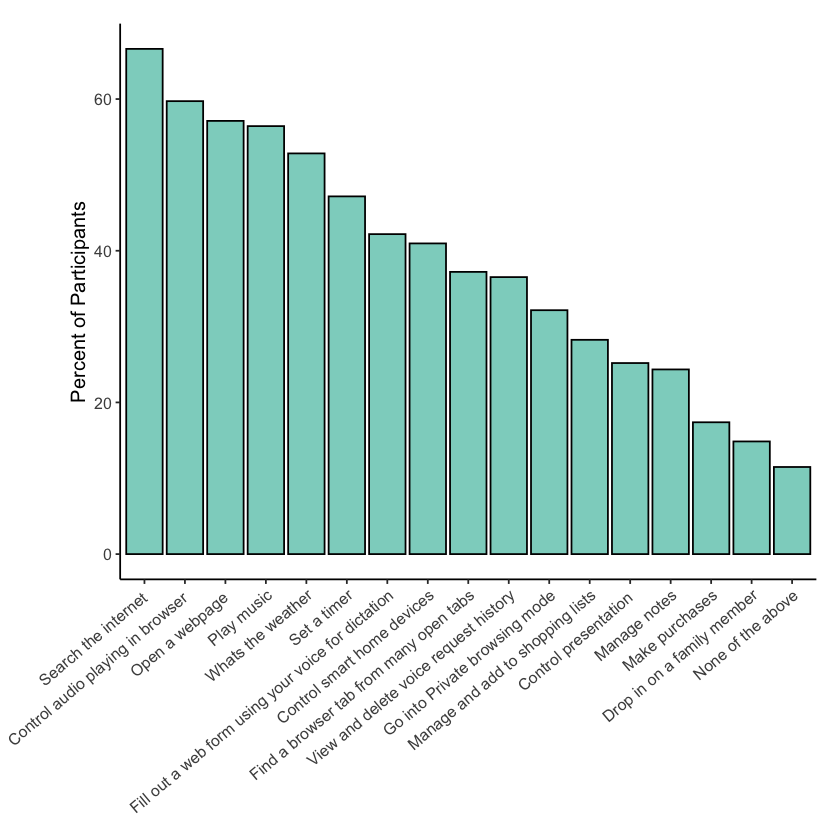

In [983]:
temp = select(df, matches("assistant_use\\."))
temp = mutate_all(temp, toBinary)
temp = as.data.frame(apply(temp, MARGIN = 2, FUN = function(x) {(sum(x)/length(x)) * 100}))
colnames(temp) = c('freq')
temp = tibble::rownames_to_column(temp, "action")
temp = subset(temp, freq != 0)
temp = mutate_at(temp, vars(matches("action")), clean_title)

ggplot(temp, aes(x = reorder(action,-freq), y = freq, fill = "", 
                 label = freq)) +
  geom_bar(stat="identity", color = "black", position=position_dodge()) + 
  labs(y = "Percent of Participants") +
  theme_classic() + 
  theme(plot.margin=unit(c(.5,.5,.5,1.5),"cm"),
        text = element_text(size=12),
        axis.text.x = element_text(angle = 40, hjust = 1, vjust = 1),
        #axis.title.y = element_blank(),
        axis.title.x = element_blank(),
        strip.background = element_blank(),
        panel.spacing = unit(3, "lines"),
        legend.position = "none") +
  guides(fill = guide_legend(title = "Rating")) +
  scale_fill_brewer(palette = "Set3", direction = -1)

ggsave("/Users/jmaddock/data/first_look/img/actions_8-14-19.png",height=5,width=7)

In [846]:
temp = select(df, matches("assistant_use\\."))
temp = mutate_all(temp, toBinary)
temp = as.data.frame(apply(temp, MARGIN = 2, FUN = function(x) {(sum(x)/length(x)) * 100}))
colnames(temp) = c('freq')
temp = tibble::rownames_to_column(temp, "action")
temp = subset(temp, freq != 0)
temp = mutate_at(temp, vars(matches("action")), clean_title)
temp[order(-temp$freq),]

,action,freq
,<chr>,<dbl>
13,Search the internet,66.61562
15,Control audio playing in browser,59.72435
12,Open a webpage,57.12098
1,Play music,56.43185
3,Whats the weather,52.83308
2,Set a timer,47.16692
14,Fill out a web form using your voice for dictation,42.18989
5,Control smart home devices,40.96478
11,Find a browser tab from many open tabs,37.21286


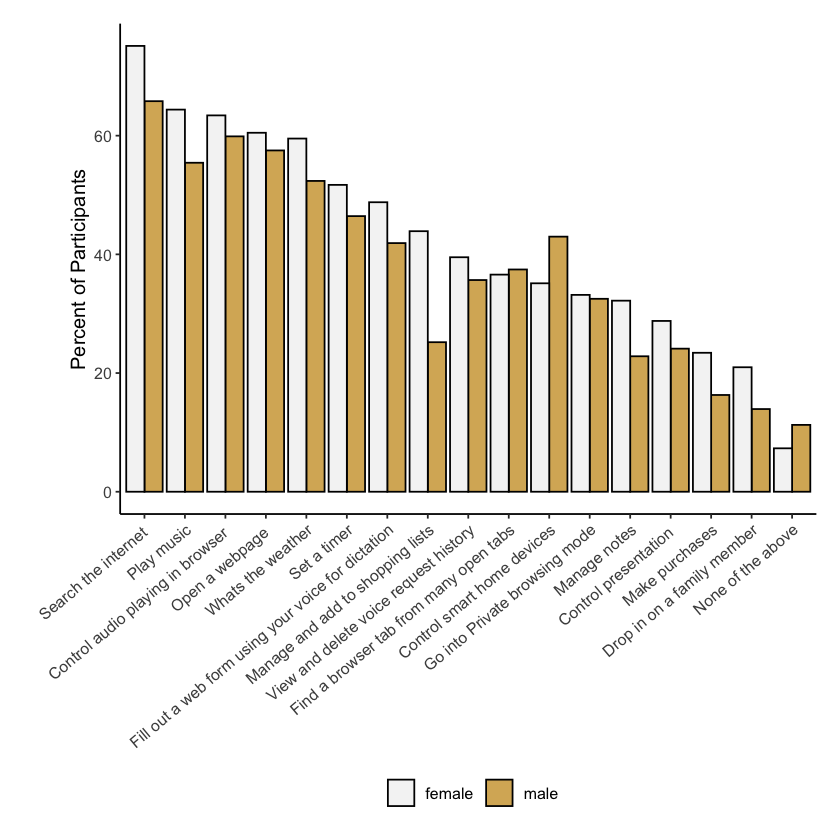

In [769]:
temp = select(df, matches("assistant_use\\.|gender"))
m = subset(temp, gender == 'male')
f = subset(temp, gender == 'female')
m = getPercent(m)
f = getPercent(f)
m$gender = 'male'
f$gender = 'female'
temp = rbind(m,f)
temp = subset(temp, action != "gender")
temp = subset(temp, freq != 0)

rank = subset(temp, gender == "female")
rank = rank[order(-rank$freq),]
rank$rank = rank(rank$freq)
temp = merge(temp,rank[c("action","rank")],by="action")

temp = mutate_at(temp, vars(matches("action")), clean_title)


ggplot(temp, aes(x = reorder(action,-rank), y = freq, fill = gender, 
                 label = freq)) +
  geom_bar(stat="identity", color = "black", position=position_dodge()) + 
  labs(y = "Percent of Participants") +
  theme_classic() + 
  theme(plot.margin=unit(c(.5,.5,.5,1.5),"cm"),
        text = element_text(size=12),
        axis.text.x = element_text(angle = 40, hjust = 1, vjust = 1),
        #axis.title.y = element_blank(),
        axis.title.x = element_blank(),
        strip.background = element_blank(),
        panel.spacing = unit(3, "lines"),
        legend.position = "bottom") +
  guides(fill = guide_legend(title = "")) +
  scale_fill_brewer(palette = "BrBG", direction = -1)

ggsave("/Users/jmaddock/data/first_look/img/gender_8-14-19.png",height=5,width=7)

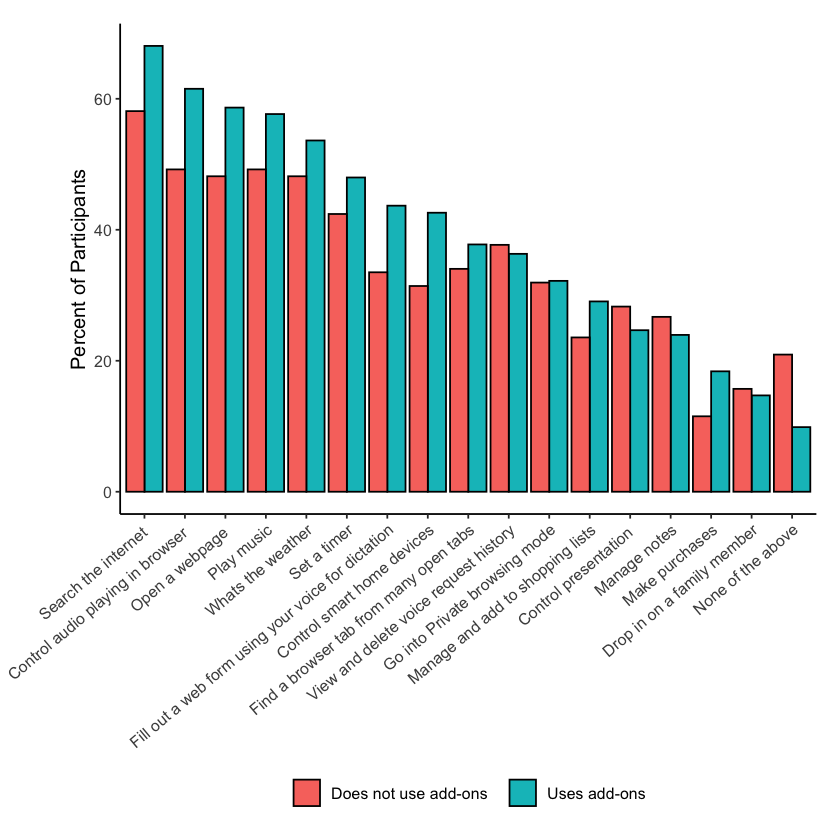

In [984]:
temp = select(df, matches("assistant_use\\.|AddOn"))
a = subset(temp, Addon2 == 'addon-true')
na = subset(temp, Addon2 != 'addon-true')
a = getPercent(a)
na = getPercent(na)
a$addOn = 'Uses add-ons'
na$addOn = 'Does not use add-ons'
temp = rbind(a,na)
temp = subset(temp, !(action %in% c("AddOn","Addon2")))
temp = subset(temp, freq != 0)

rank = subset(temp, addOn == "Uses add-ons")
rank = rank[order(-rank$freq),]
rank$rank = rank(rank$freq)
temp = merge(temp,rank[c("action","rank")],by="action")

temp = mutate_at(temp, vars(matches("action")), clean_title)


ggplot(temp, aes(x = reorder(action,-rank), y = freq, fill = addOn, 
                 label = freq)) +
  geom_bar(stat="identity", color = "black", position=position_dodge()) + 
  labs(y = "Percent of Participants") +
  theme_classic() + 
  theme(plot.margin=unit(c(.5,.5,.5,1.5),"cm"),
        text = element_text(size=12),
        axis.text.x = element_text(angle = 40, hjust = 1, vjust = 1),
        #axis.title.y = element_blank(),
        axis.title.x = element_blank(),
        strip.background = element_blank(),
        panel.spacing = unit(3, "lines"),
        legend.position = "bottom") +
  guides(fill = guide_legend(title = "")) +
  #scale_fill_brewer(palette = "BrBG", direction = -1)

ggsave("/Users/jmaddock/data/first_look/img/addon_8-14-19.png",height=5,width=7)

In [724]:
col_name_list = colnames(select(df, matches("assistant_use\\.")))

m = subset(df, gender == 'male')
f = subset(df, gender == 'female')
m = mutate_all(m, toBinary)
f = mutate_all(f, toBinary)

#as.vector(t(f['assistant_use.Play_music']))

result = data.frame(0,0,0,0,0)
names(result) = c('var','z','p','*','mean_diff')

for (col_name in col_name_list) {
    mtemp = as.vector(t(m[col_name]))
    ftemp = as.vector(t(f[col_name]))
    z = z.test(y=mtemp, x=ftemp, mu = 0, sigma.y = sd(mtemp), sigma.x = sd(ftemp))
    if (z$p.value != 'NaN' && z$p.value < .05) {
        p = '*'
    } else {
        p = ''
    }
    z_df = data.frame(col_name, z$statistic, round(z$p.value,3), p, mean(ftemp)-mean(mtemp))
    names(z_df) = c('var','z','p','*','mean_diff')
    result = rbind(result, z_df)
}

result


,var,z,p,*,mean_diff
,<chr>,<dbl>,<dbl>,<chr>,<dbl>
1,0,0.0000000,0.000,0,0.000000000
z,assistant_use.Play_music,2.4209793,0.015,*,0.089554613
z1,assistant_use.Search_the_web,NaN,NaN,,0.000000000
z2,assistant_use.Set_a_timer,1.3730802,0.170,,0.052646293
z3,assistant_use.Whats_the_weather,1.8897100,0.059,,0.071406536
z4,assistant_use.Drop_in_on_a_family_member,2.3079965,0.021,*,0.070428034
z5,assistant_use.Control_smart_home_devices,-2.1324243,0.033,*,-0.078622385
z6,"assistant_use.Control_presentation_e.g._""Next_slide""",1.3561334,0.175,,0.046698159
z7,assistant_use.Make_purchases,2.2328894,0.026,*,0.071102863


In [744]:
col_name_list = colnames(select(df, matches("assistant_use\\.")))

a = subset(df, Addon2 == 'addon-true')
na = subset(df, Addon2 != 'addon-true')
a = mutate_all(a, toBinary)
na = mutate_all(na, toBinary)

#as.vector(t(f['assistant_use.Play_music']))

result = data.frame(0,0,0,0,0)
names(result) = c('var','z','p','*','mean_diff')

for (col_name in col_name_list) {
    atemp = as.vector(t(a[col_name]))
    natemp = as.vector(t(na[col_name]))
    z = z.test(y=atemp, x=natemp, mu = 0, sigma.y = sd(atemp), sigma.x = sd(natemp))
    if (z$p.value != 'NaN' && z$p.value < .05) {
        p = '*'
    } else {
        p = ''
    }
    z_df = data.frame(col_name, z$statistic, round(z$p.value,3), p, mean(natemp)-mean(atemp))
    names(z_df) = c('var','z','p','*','mean_diff')
    result = rbind(result, z_df)
}

result

,var,z,p,*,mean_diff
,<chr>,<dbl>,<dbl>,<chr>,<dbl>
1,0,0.00000000,0.000,0,0.000000000
z,assistant_use.Play_music,-2.15793629,0.031,*,-0.084535017
z1,assistant_use.Search_the_web,NaN,NaN,,0.000000000
z2,assistant_use.Set_a_timer,-1.43458028,0.151,,-0.055736858
z3,assistant_use.Whats_the_weather,-1.39378971,0.163,,-0.054647477
z4,assistant_use.Drop_in_on_a_family_member,0.35088261,0.726,,0.009982861
z5,assistant_use.Control_smart_home_devices,-3.04088329,0.002,*,-0.111872843
z6,"assistant_use.Control_presentation_e.g._""Next_slide""",1.02720827,0.304,,0.036085742
z7,assistant_use.Make_purchases,-2.65090789,0.008,*,-0.068673256


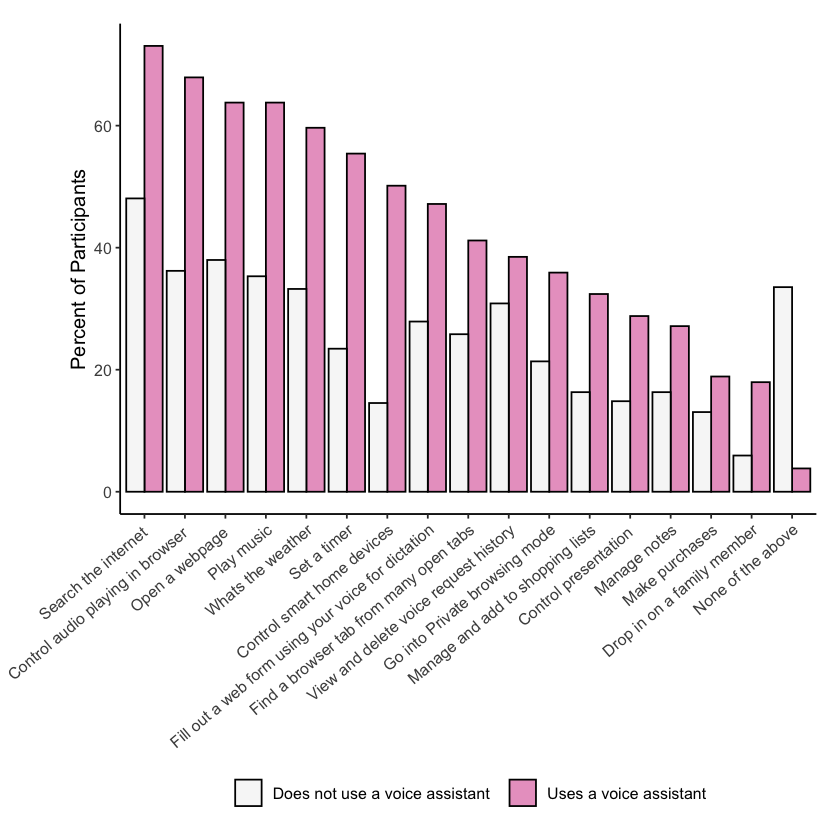

In [985]:
temp = select(df, matches("assistant_use\\.|voice_assistant"))
a = subset(temp, voice_assistant == 'Yes')
na = subset(temp, voice_assistant != 'Yes')
a = getPercent(a)
na = getPercent(na)
a$assistant = 'Uses a voice assistant'
na$assistant = 'Does not use a voice assistant'
temp = rbind(a,na)
temp = subset(temp, !(action %in% c("voice_assistant")))
temp = subset(temp, freq != 0)

rank = subset(temp, assistant == "Uses a voice assistant")
rank = rank[order(-rank$freq),]
rank$rank = rank(rank$freq)
temp = merge(temp,rank[c("action","rank")],by="action")

temp = mutate_at(temp, vars(matches("action")), clean_title)


ggplot(temp, aes(x = reorder(action,-rank), y = freq, fill = assistant, 
                 label = freq)) +
  geom_bar(stat="identity", color = "black", position=position_dodge()) + 
  labs(y = "Percent of Participants") +
  theme_classic() + 
  theme(plot.margin=unit(c(.5,.5,.5,1.5),"cm"),
        text = element_text(size=12),
        axis.text.x = element_text(angle = 40, hjust = 1, vjust = 1),
        #axis.title.y = element_blank(),
        axis.title.x = element_blank(),
        strip.background = element_blank(),
        panel.spacing = unit(3, "lines"),
        legend.position = "bottom") +
  guides(fill = guide_legend(title = "")) +
  scale_fill_brewer(palette = "PiYG", direction = -1)

ggsave("/Users/jmaddock/data/first_look/img/assistant_8-14-19.png",height=5,width=7)

In [765]:
col_name_list = colnames(select(df, matches("assistant_use\\.")))

a = subset(df, voice_assistant == 'Yes')
na = subset(df, voice_assistant != 'Yes')
a = mutate_all(a, toBinary)
na = mutate_all(na, toBinary)

#as.vector(t(f['assistant_use.Play_music']))

result = data.frame(0,0,0,0,0)
names(result) = c('var','z','p','*','mean_diff')

for (col_name in col_name_list) {
    atemp = as.vector(t(a[col_name]))
    natemp = as.vector(t(na[col_name]))
    z = z.test(y=atemp, x=natemp, mu = 0, sigma.y = sd(atemp), sigma.x = sd(natemp))
    if (z$p.value != 'NaN' && z$p.value < .05) {
        p = '*'
    } else {
        p = ''
    }
    z_df = data.frame(col_name, z$statistic, round(z$p.value,3), p, mean(natemp)-mean(atemp))
    names(z_df) = c('var','z','p','*','mean_diff')
    result = rbind(result, z_df)
}

result

,var,z,p,*,mean_diff
,<chr>,<dbl>,<dbl>,<chr>,<dbl>
1,0,0.000000,0.000,0,0.00000000
z,assistant_use.Play_music,-9.392501,0.000,*,-0.28465517
z1,assistant_use.Search_the_web,NaN,NaN,,0.00000000
z2,assistant_use.Set_a_timer,-11.381076,0.000,*,-0.31975820
z3,assistant_use.Whats_the_weather,-8.761022,0.000,*,-0.26414701
z4,assistant_use.Drop_in_on_a_family_member,-6.737981,0.000,*,-0.12021938
z5,assistant_use.Control_smart_home_devices,-14.210909,0.000,*,-0.35614739
z6,"assistant_use.Control_presentation_e.g._""Next_slide""",-5.755957,0.000,*,-0.13955774
z7,assistant_use.Make_purchases,-2.617064,0.009,*,-0.05829069


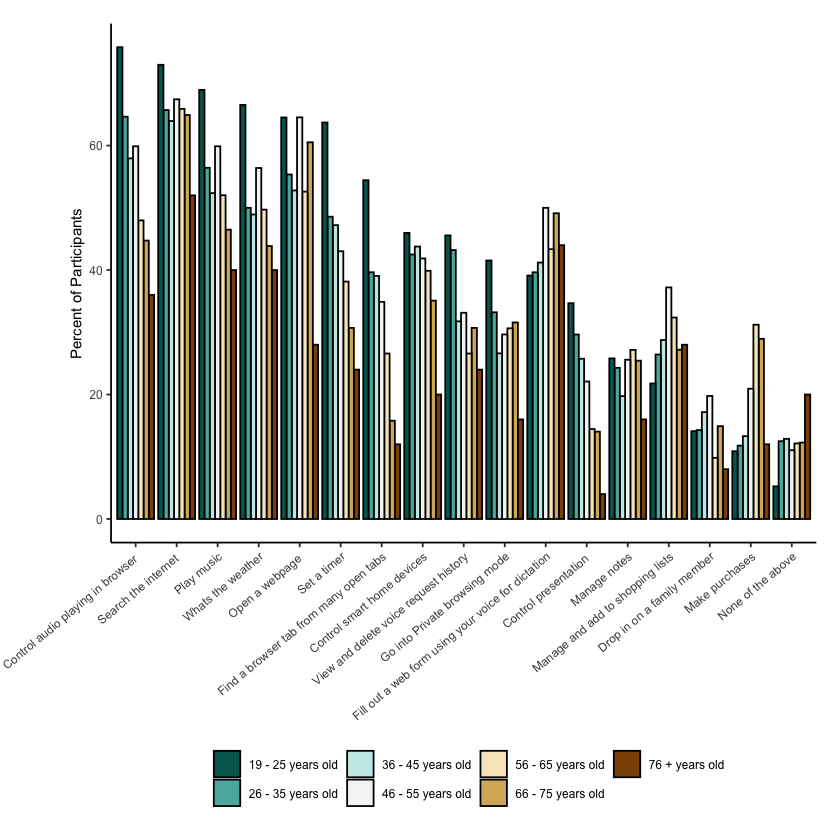

In [822]:
temp = select(df, matches("assistant_use\\.|^age$"))
result = data.frame(0,0,0)
names(result) = c("action","freq","age")

for (val in unique(df$age)) {
    sub = subset(temp, age == val)
    sub = getPercent(sub)
    sub$age = val
    result = rbind(result,sub)
}


result = subset(result, !(action %in% c("age")))
result = subset(result, freq != 0)

rank = subset(result, age == "19 - 25 years old")
rank = rank[order(-rank$freq),]
rank$rank = rank(rank$freq)
result = merge(result,rank[c("action","rank")],by="action")

result = mutate_at(result, vars(matches("action")), clean_title)


ggplot(result, aes(x = reorder(action,-rank), y = freq, fill = age, 
                 label = freq)) +
  geom_bar(stat="identity", color = "black", position=position_dodge()) + 
  labs(y = "Percent of Participants") +
  theme_classic() + 
  theme(plot.margin=unit(c(.5,.5,.5,1.5),"cm"),
        text = element_text(size=9),
        axis.text.x = element_text(angle = 40, hjust = 1, vjust = 1),
        #axis.title.y = element_blank(),
        axis.title.x = element_blank(),
        strip.background = element_blank(),
        panel.spacing = unit(3, "lines"),
        legend.position = "bottom") +
  guides(fill = guide_legend(title = "")) +
  scale_fill_brewer(palette = "BrBG", direction = -1)

ggsave("/Users/jmaddock/data/first_look/img/age_8-14-19.png",height=5,width=7)

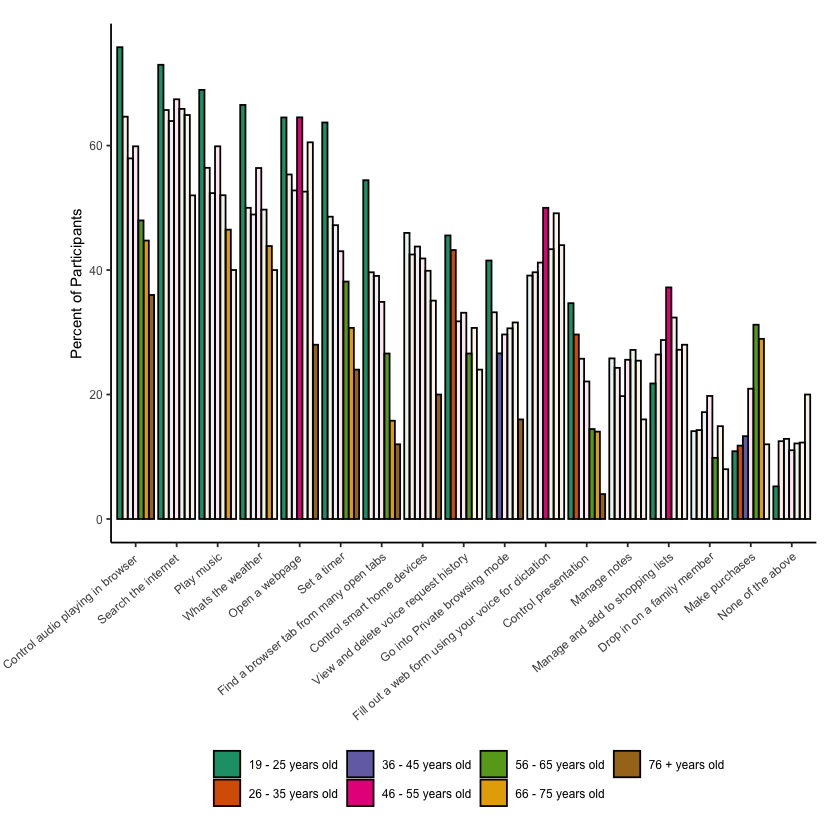

In [956]:
temp = select(df, matches("assistant_use\\.|^age$"))
temp = mutate_at(temp, vars(matches("assistant_use\\.")), toBinary)

#result = subset(result, !(action %in% c("age")))
#result = subset(result, freq != 0)

col_name_list = colnames(select(df, matches("assistant_use\\.")))
zresult = data.frame(0,0,0,0,0,0)
names(zresult) = c('action','age','z','p','sig','mean_diff')

for (col_name in col_name_list) {
    for (val in levels(df$age)) {
        if (val != "NA") {
            x = subset(temp, age == val)
            #print(x)
            y = subset(temp, age != val)
            x = as.vector(t(x[col_name]))
            #print(x)
            y = as.vector(t(y[col_name]))
            z = z.test(y=y, x=x, mu = 0, sigma.y = sd(y), sigma.x = sd(x))
            if (z$p.value != 'NaN' && z$p.value < .05) {
                p = 1
            } else {
                p = .1
            }
            z_df = data.frame(col_name, val, z$statistic, round(z$p.value,3), p, mean(natemp)-mean(atemp))
            names(z_df) = c('action','age','z','p','sig','mean_diff')
            zresult = rbind(zresult, z_df)
        }
    }
}

zresult = mutate_at(zresult, vars(matches("action")), clean_title)
#zresult

temp = select(df, matches("assistant_use\\.|^age$"))
result = data.frame(0,0,0)
names(result) = c("action","freq","age")

for (val in unique(df$age)) {
    sub = subset(temp, age == val)
    sub = getPercent(sub)
    sub$age = val
    result = rbind(result,sub)
}


result = subset(result, !(action %in% c("age")))
result = subset(result, freq != 0)

rank = subset(result, age == "19 - 25 years old")
rank = rank[order(-rank$freq),]
rank$rank = rank(rank$freq)
result = merge(result,rank[c("action","rank")],by="action")

result = mutate_at(result, vars(matches("action")), clean_title)

result = merge(result, select(zresult, c('action','age','sig')), by = c('action','age'))

ggplot(result, aes(x = reorder(action,-rank), y = freq, fill = age, 
                 label = freq, alpha = sig)) +
  geom_bar(stat="identity", color = "black", position=position_dodge()) + 
  labs(y = "Percent of Participants") +
  scale_alpha(range = c(.1,1.0), guide = 'none') +
  theme_classic() + 
  theme(plot.margin=unit(c(.5,.5,.5,1.5),"cm"),
        text = element_text(size=9),
        axis.text.x = element_text(angle = 40, hjust = 1, vjust = 1),
        #axis.title.y = element_blank(),
        axis.title.x = element_blank(),
        strip.background = element_blank(),
        panel.spacing = unit(3, "lines"),
        legend.position = "bottom") +
  guides(fill = guide_legend(title = "")) +
  #scale_fill_manual(values = wes_palette("FantasticFox1", n = 7))
  scale_fill_brewer(palette = "Dark2")

ggsave("/Users/jmaddock/data/first_look/img/age_alpha_8-15-19.png",height=5,width=7)

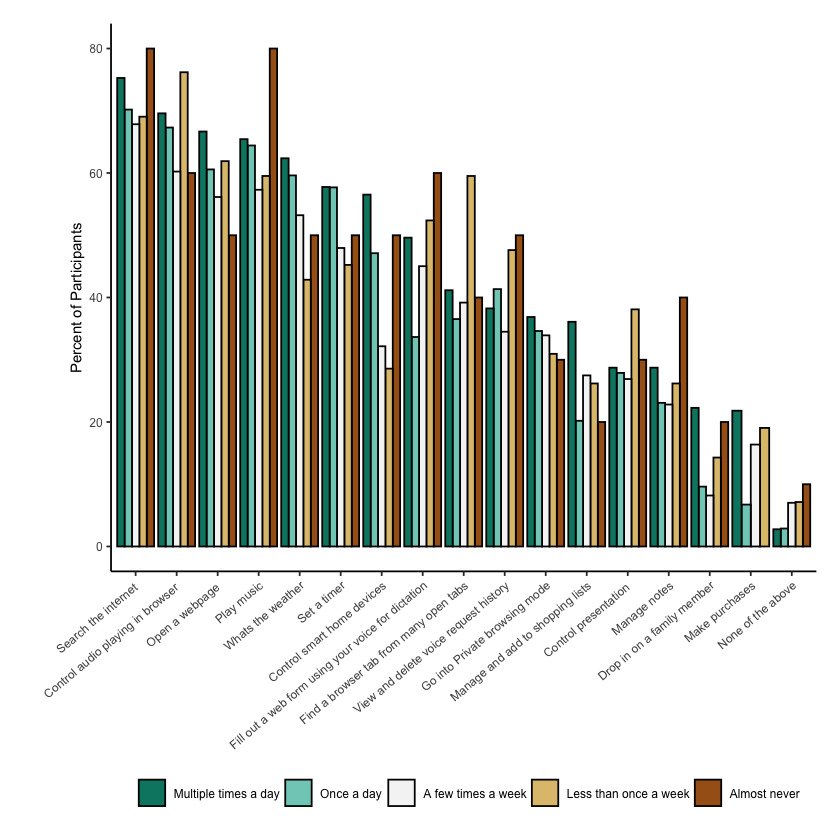

In [842]:
temp = select(df, matches("assistant_use\\.|^assistant_use_frequency$"))
result = data.frame(0,0,0)
names(result) = c("action","freq","assistant_use_frequency")

for (val in unique(df$assistant_use_frequency)) {
    sub = subset(temp, assistant_use_frequency == val)
    sub = getPercent(sub)
    sub$assistant_use_frequency = val
    result = rbind(result,sub)
}

result = subset(result, !(action %in% c("assistant_use_frequency")))
result = subset(result, freq != 0)

result$assistant_use_frequency = ordered(result$assistant_use_frequency, levels = c('Multiple times a day',
                                                                            'Once a day',
                                                                            'A few times a week',
                                                                            'Less than once a week',
                                                                            'Almost never'))

rank = subset(result, assistant_use_frequency == "Multiple times a day")
rank = rank[order(-rank$freq),]
rank$rank = rank(rank$freq)
result = merge(result,rank[c("action","rank")],by="action")

result = mutate_at(result, vars(matches("action")), clean_title)


ggplot(result, aes(x = reorder(action,-rank), y = freq, fill = assistant_use_frequency, 
                 label = freq)) +
  geom_bar(stat="identity", color = "black", position=position_dodge()) + 
  labs(y = "Percent of Participants") +
  theme_classic() + 
  theme(plot.margin=unit(c(.5,.5,.5,1.5),"cm"),
        text = element_text(size=9),
        axis.text.x = element_text(angle = 40, hjust = 1, vjust = 1),
        #axis.title.y = element_blank(),
        axis.title.x = element_blank(),
        strip.background = element_blank(),
        panel.spacing = unit(3, "lines"),
        legend.position = "bottom") +
  guides(fill = guide_legend(title = "")) +
  scale_fill_brewer(palette = "BrBG", direction = -1)

ggsave("/Users/jmaddock/data/first_look/img/assistant_use_8-14-19.png",height=5,width=7)

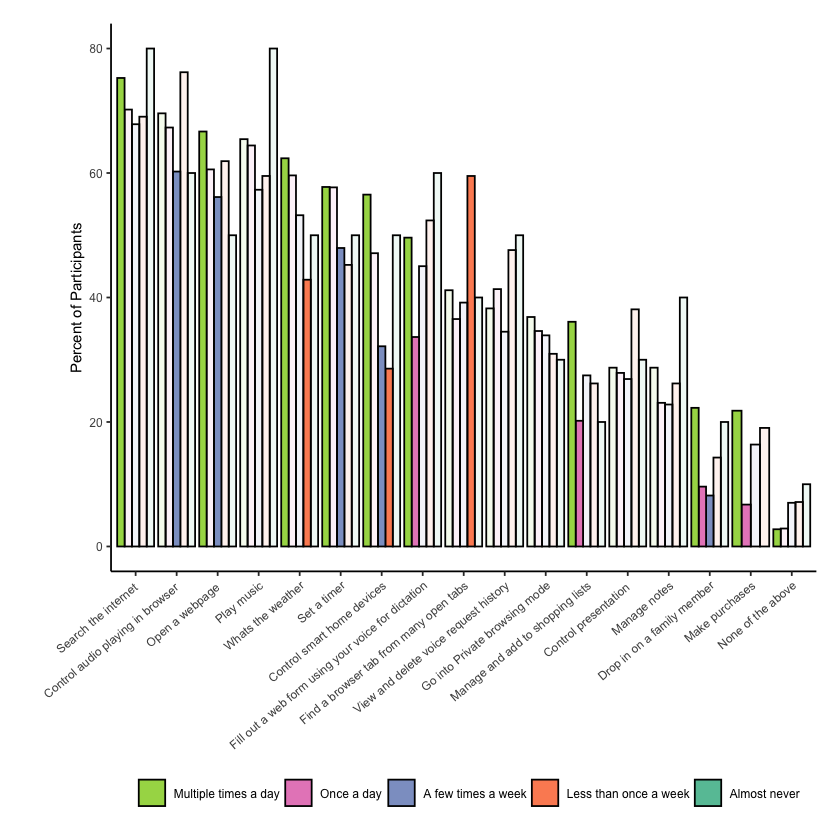

In [1000]:
temp = select(df, matches("assistant_use\\.|^assistant_use_frequency$"))
temp = mutate_at(temp, vars(matches("assistant_use\\.")), toBinary)

#result = subset(result, !(action %in% c("assistant_use_frequency")))
#result = subset(result, freq != 0)

col_name_list = colnames(select(df, matches("assistant_use\\.")))
zresult = data.frame(0,0,0,0,0,0)
names(zresult) = c('action','assistant_use_frequency','z','p','sig','mean_diff')

for (col_name in col_name_list) {
    for (val in levels(df$assistant_use_frequency)) {
        if (val != "NA") {
            x = subset(temp, assistant_use_frequency == val)
            #print(x)
            y = subset(temp, assistant_use_frequency != val)
            x = as.vector(t(x[col_name]))
            #print(x)
            y = as.vector(t(y[col_name]))
            z = z.test(y=y, x=x, mu = 0, sigma.y = sd(y), sigma.x = sd(x))
            if (z$p.value != 'NaN' && z$p.value < .05) {
                p = 1
            } else {
                p = .1
            }
            z_df = data.frame(col_name, val, z$statistic, round(z$p.value,3), p, mean(natemp)-mean(atemp))
            names(z_df) = c('action','assistant_use_frequency','z','p','sig','mean_diff')
            zresult = rbind(zresult, z_df)
        }
    }
}

zresult = mutate_at(zresult, vars(matches("action")), clean_title)
#zresult

temp = select(df, matches("assistant_use\\.|^assistant_use_frequency$"))
result = data.frame(0,0,0)
names(result) = c("action","freq","assistant_use_frequency")

for (val in unique(df$assistant_use_frequency)) {
    sub = subset(temp, assistant_use_frequency == val)
    sub = getPercent(sub)
    sub$assistant_use_frequency = val
    result = rbind(result,sub)
}


result = subset(result, !(action %in% c("assistant_use_frequency")))
result = subset(result, freq != 0)

rank = subset(result, assistant_use_frequency == "Multiple times a day")
rank = rank[order(-rank$freq),]
rank$rank = rank(rank$freq)
result = merge(result,rank[c("action","rank")],by="action")

result = mutate_at(result, vars(matches("action")), clean_title)

result = merge(result, select(zresult, c('action','assistant_use_frequency','sig')), by = c('action','assistant_use_frequency'))

result$assistant_use_frequency = ordered(result$assistant_use_frequency, levels = c('Multiple times a day',
                                                                            'Once a day',
                                                                            'A few times a week',
                                                                            'Less than once a week',
                                                                            'Almost never'))

ggplot(result, aes(x = reorder(action,-rank), y = freq, fill = assistant_use_frequency, 
                 label = freq, alpha = sig)) +
  geom_bar(stat="identity", color = "black", position=position_dodge()) + 
  labs(y = "Percent of Participants") +
  scale_alpha(range = c(.1,1.0), guide = 'none') +
  theme_classic() + 
  theme(plot.margin=unit(c(.5,.5,.5,1.5),"cm"),
        text = element_text(size=9),
        axis.text.x = element_text(angle = 40, hjust = 1, vjust = 1),
        #axis.title.y = element_blank(),
        axis.title.x = element_blank(),
        strip.background = element_blank(),
        panel.spacing = unit(3, "lines"),
        legend.position = "bottom") +
  guides(fill = guide_legend(title = "")) +
  #scale_fill_manual(values = wes_palette("Darjeeling1", n = 5))
  scale_fill_brewer(palette = "Set2", direction = -1)

ggsave("/Users/jmaddock/data/first_look/img/assistant_use_alpha_8-15-19.png",height=5,width=7)

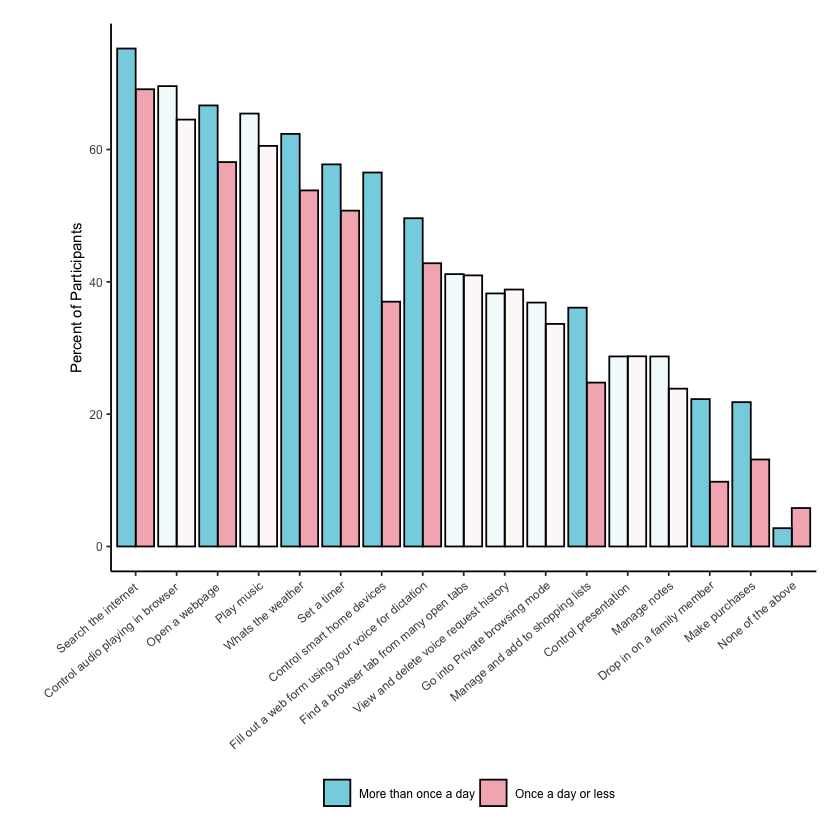

In [1015]:
temp = select(df, matches("assistant_use\\.|^assistant_use_frequency.simple$"))
temp = mutate_at(temp, vars(matches("assistant_use\\.")), toBinary)

#result = subset(result, !(action %in% c("assistant_use_frequency.simple")))
#result = subset(result, freq != 0)

col_name_list = colnames(select(df, matches("assistant_use\\.")))
zresult = data.frame(0,0,0,0,0,0)
names(zresult) = c('action','assistant_use_frequency.simple','z','p','sig','mean_diff')

for (col_name in col_name_list) {
    for (val in levels(df$assistant_use_frequency.simple)) {
        if (val != "NA") {
            x = subset(temp, assistant_use_frequency.simple == val)
            #print(x)
            y = subset(temp, assistant_use_frequency.simple != val)
            x = as.vector(t(x[col_name]))
            #print(x)
            y = as.vector(t(y[col_name]))
            z = z.test(y=y, x=x, mu = 0, sigma.y = sd(y), sigma.x = sd(x))
            if (z$p.value != 'NaN' && z$p.value < .05) {
                p = 1
            } else {
                p = .1
            }
            z_df = data.frame(col_name, val, z$statistic, round(z$p.value,3), p, mean(natemp)-mean(atemp))
            names(z_df) = c('action','assistant_use_frequency.simple','z','p','sig','mean_diff')
            zresult = rbind(zresult, z_df)
        }
    }
}

zresult = mutate_at(zresult, vars(matches("action")), clean_title)
#zresult

temp = select(df, matches("assistant_use\\.|^assistant_use_frequency.simple$"))
result = data.frame(0,0,0)
names(result) = c("action","freq","assistant_use_frequency.simple")

for (val in unique(df$assistant_use_frequency.simple)) {
    sub = subset(temp, assistant_use_frequency.simple == val)
    sub = getPercent(sub)
    sub$assistant_use_frequency.simple = val
    result = rbind(result,sub)
}


result = subset(result, !(action %in% c("assistant_use_frequency.simple")))
result = subset(result, freq != 0)

rank = subset(result, assistant_use_frequency.simple == "Multiple times a day")
rank = rank[order(-rank$freq),]
rank$rank = rank(rank$freq)
result = merge(result,rank[c("action","rank")],by="action")

result = mutate_at(result, vars(matches("action")), clean_title)

result = merge(result, select(zresult, c('action','assistant_use_frequency.simple','sig')), by = c('action','assistant_use_frequency.simple'))

result$assistant_use_frequency.simple = ordered(result$assistant_use_frequency.simple,
                                                levels = c('Multiple times a day',
                                                           'Once a day'),
                                                labels = c('More than once a day',
                                                           'Once a day or less'))

ggplot(result, aes(x = reorder(action,-rank), y = freq, fill = assistant_use_frequency.simple, 
                 label = freq, alpha = sig)) +
  geom_bar(stat="identity", color = "black", position=position_dodge()) + 
  labs(y = "Percent of Participants") +
  scale_alpha(range = c(.1,1.0), guide = 'none') +
  theme_classic() + 
  theme(plot.margin=unit(c(.5,.5,.5,1.5),"cm"),
        text = element_text(size=9),
        axis.text.x = element_text(angle = 40, hjust = 1, vjust = 1),
        #axis.title.y = element_blank(),
        axis.title.x = element_blank(),
        strip.background = element_blank(),
        panel.spacing = unit(3, "lines"),
        legend.position = "bottom") +
  guides(fill = guide_legend(title = "")) +
  scale_fill_manual(values = wes_palette("Moonrise3", n = 5))
  #scale_fill_brewer(palette = "Set2", direction = -1)

ggsave("/Users/jmaddock/data/first_look/img/assistant_use_simple_alpha_8-15-19.png",height=5,width=7)

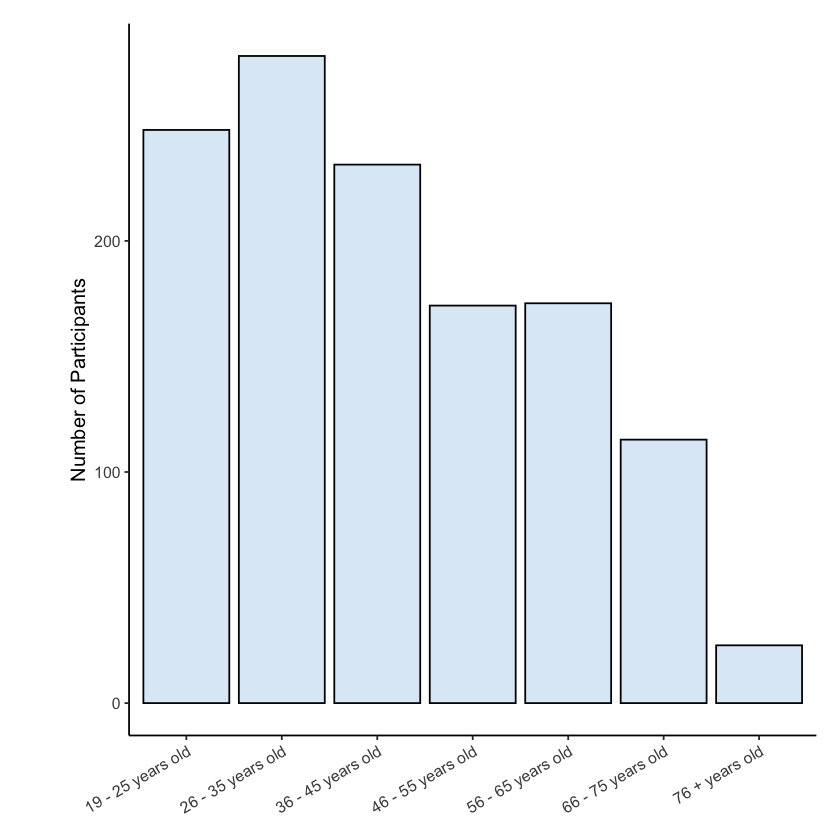

In [1003]:
temp = as.data.frame(table(df['age']))

ggplot(temp, aes(x = Var1, y = Freq, fill = "", 
                 label = Freq, )) +
  geom_bar(stat="identity", color = "black") + 
  labs(y = "Number of Participants") +
  scale_alpha(range = c(.1,1.0), guide = 'none') +
  theme_classic() + 
  theme(plot.margin=unit(c(.5,.5,.5,1.5),"cm"),
        text = element_text(size=12),
        axis.text.x = element_text(angle = 30, hjust = 1, vjust = 1),
        #axis.title.y = element_blank(),
        axis.title.x = element_blank(),
        strip.background = element_blank(),
        panel.spacing = unit(3, "lines"),
        legend.position = "none") +
  guides(fill = guide_legend(title = "")) + 
  #scale_fill_manual(values = wes_palette("Darjeeling1", n = 5))
  scale_fill_brewer(palette = "Blues", direction = -1)

ggsave("/Users/jmaddock/data/first_look/img/age_stat_8-15-19.png",height=3,width=7)

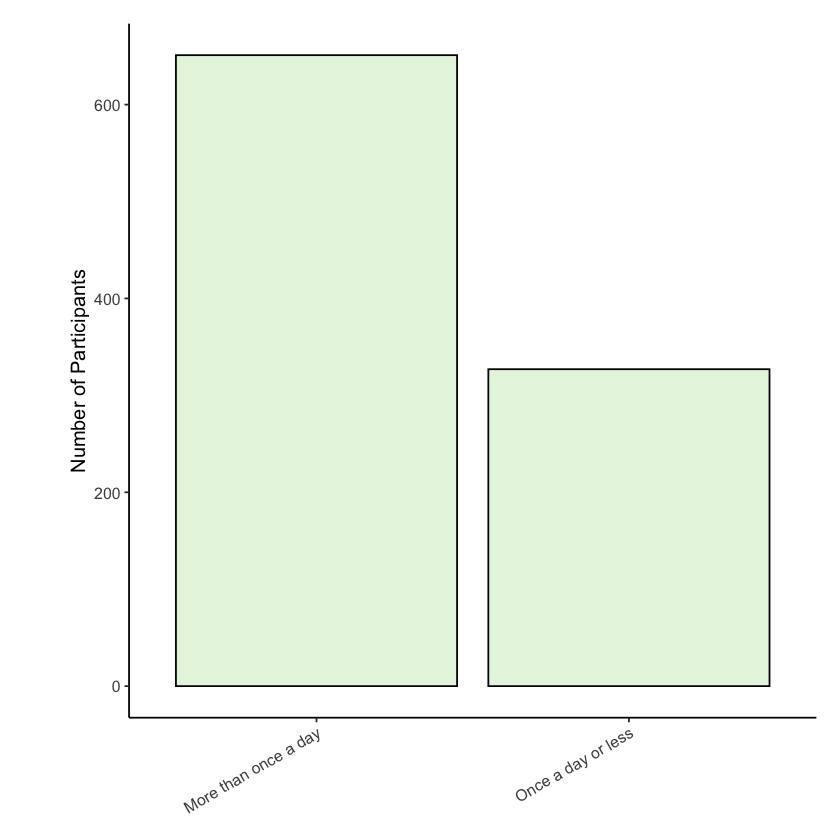

In [1018]:
temp = df
temp$assistant_use_frequency.simple = ordered(df$assistant_use_frequency.simple,
                                                levels = c('Multiple times a day',
                                                           'Once a day'),
                                                labels = c('More than once a day',
                                                           'Once a day or less'))

temp = as.data.frame(table(temp['assistant_use_frequency.simple']))

ggplot(temp, aes(x = Var1, y = Freq, fill = "", 
                 label = Freq, )) +
  geom_bar(stat="identity", color = "black") + 
  labs(y = "Number of Participants") +
  scale_alpha(range = c(.1,1.0), guide = 'none') +
  theme_classic() + 
  theme(plot.margin=unit(c(.5,.5,.5,1.5),"cm"),
        text = element_text(size=12),
        axis.text.x = element_text(angle = 30, hjust = 1, vjust = 1),
        #axis.title.y = element_blank(),
        axis.title.x = element_blank(),
        strip.background = element_blank(),
        panel.spacing = unit(3, "lines"),
        legend.position = "none") +
  guides(fill = guide_legend(title = "")) + 
  #scale_fill_manual(values = wes_palette("Darjeeling1", n = 5))
  scale_fill_brewer(palette = "Greens", direction = -1)

ggsave("/Users/jmaddock/data/first_look/img/use_stat_8-15-19.png",height=3,width=7)